In [1]:
# importing all necessary libraries...
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# load dataset...
Data = pd.read_csv('./archive/creditcard.csv')

In [3]:
# preprocessing Time column in dataset...
Data["Time"] = Data["Time"].apply(lambda x : x / 3600 % 24)

In [4]:
Data["Time"][:5]

0    0.000000
1    0.000000
2    0.000278
3    0.000278
4    0.000556
Name: Time, dtype: float64

In [5]:
non_fraud = Data[Data['Class'] == 0]
fraud = Data[Data['Class'] == 1]

print((fraud.shape, non_fraud.shape))

((492, 31), (284315, 31))


In [6]:
# sampling 1000 non-fraud for 2D visulaization...
non_fraud = Data[Data['Class'] == 0].sample(600)
fraud = Data[Data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

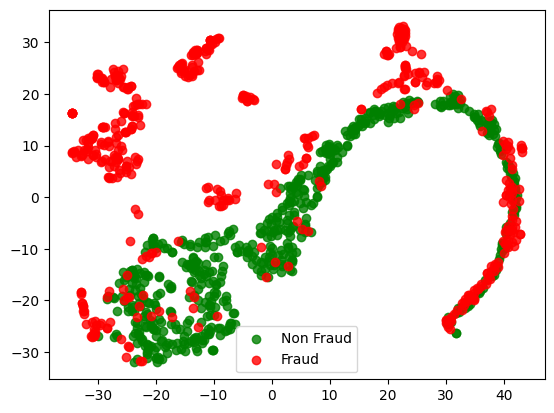

In [7]:
# helper function for TSNE visualization...
def tsne_plot(x1, y1):
    tsne = TSNE()
    X_t = tsne.fit_transform(x1)

    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
    plt.legend(loc='lower center')
    plt.show()
    
tsne_plot(X, Y)

In [8]:
# create VAE model structure..
input_shape = X.shape[1:]

latent_dim = 3

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        encoder_input = tf.keras.layers.Input(shape=input_shape)
        x = tf.keras.layers.Dense(64, activation='relu')(encoder_input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # Encoder outputs
        z_mean = tf.keras.layers.Dense(self.latent_dim)(x)
        z_log_var = tf.keras.layers.Dense(self.latent_dim)(x)

        return tf.keras.models.Model(encoder_input, [z_mean, z_log_var])

    def build_decoder(self):
        decoder_input = tf.keras.layers.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(32, activation='relu')(decoder_input)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # Decoder output
        output = tf.keras.layers.Dense(input_shape[0], activation='sigmoid')(x)

        return tf.keras.models.Model(decoder_input, output)

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        self.z_mean = z_mean
        self.z_log_var = z_log_var
        return self.decoder(z)

def vae_loss(y_true, y_pred):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_true, y_pred))
    kl_loss = -0.5 * tf.reduce_sum(1 + vae.z_log_var - tf.square(vae.z_mean) - tf.exp(vae.z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

vae = VAE(latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001
), loss=vae_loss)

In [9]:
dummy_input = tf.zeros((1, input_shape[0]))
_ = vae(dummy_input)

In [10]:
# load modelWeights from previous training
vae.load_weights('modelWeights.h5')

In [ ]:
# display structure of VAE
print(vae.encoder.summary())
print(vae.decoder.summary())

In [11]:
# Load test dataset
trainData = pd.read_csv('./trainDataset').astype('float32')
trainData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.259645,-0.478193,-2.286159,-0.000251,1.354913,-1.601628,0.242634,0.545117,-0.048345,0.434052,...,1.552637,-0.161906,-2.085482,0.169077,-0.239182,-0.811634,-0.261025,0.448622,4.558611,NaN
1,76857.000000,1.140208,1.156431,-1.471578,2.076278,0.774809,-1.002532,0.264948,0.013162,0.248835,...,-0.387895,-0.866812,-0.121583,-0.356109,0.634573,-0.306311,0.094087,0.121065,1.000000,1.0
2,-0.887926,-0.872405,-0.430088,1.926253,-0.629784,0.441638,0.762737,-0.580187,1.021680,0.366939,...,0.350384,0.548719,0.312049,-0.933874,-0.366917,2.021190,0.078928,0.109943,-0.184514,NaN
3,143434.000000,-2.729482,3.312495,-4.242711,5.036985,-0.376561,-1.532462,-3.449158,1.856839,-3.623334,...,0.727415,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1.000000,1.0
4,-1.407487,-0.432214,0.601033,0.955554,-0.042109,-0.382789,-0.149730,-0.135661,0.849736,-0.637249,...,0.861075,1.462258,-0.170182,0.423526,-1.035464,0.765936,0.066776,0.161300,-0.354154,NaN


In [ ]:
# Dataset preprocessing
trainData["Time"] = trainData["Time"].apply(lambda x : x / 3600 % 24)
trainData.fillna(0, inplace=True)

In [ ]:
trainData.head()

In [ ]:
nonfraud = trainData[trainData['Class'] == 0]
fraud = trainData[trainData['Class'] == 1]

In [ ]:
dataset = pd.concat([nonfraud, fraud]).sample(frac=1).reset_index(drop=True)
datasetLabel = dataset["Class"].values
dataset = dataset.drop(['Class'], axis = 1).values

dataset = (dataset - dataset.mean()) / dataset.std()

In [ ]:
mean = vae.encoder.predict(dataset)

In [ ]:
mean

In [ ]:
tca = TSNE(n_components=2)
trans = tca.fit_transform(mean)

In [ ]:
plt.scatter(trans[:, 0], trans[:, 1], s=20)
plt.show()

In [ ]:
tsne_plot(mean, datasetLabel)